<a href="https://colab.research.google.com/github/twishackaul/AG-CGAN_Attention-Guided-Conditional-GAN/blob/main/After_AG_CGAN_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Model

In [ ]:
from tensorflow.keras.layers import (Input, Dense, Flatten, Reshape, Conv2D,
                                     Conv2DTranspose, Embedding, Multiply,
                                     BatchNormalization, LeakyReLU, GlobalAveragePooling2D)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:08<00:00, 295MB/s]
100% 2.29G/2.29G [00:08<00:00, 278MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip")
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import os

dataset_dir = '/content/chest_xray'
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if os.path.getsize(file_path) == 0:  # Check for zero-byte files
            print(f"Empty file detected and removed: {file_path}")
            os.remove(file_path)  # Remove the empty file

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/chest_xray/train",
    label_mode = 'int',     # for conditional GAN
    shuffle = True,
    image_size = (256, 256),
    batch_size = 64
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/chest_xray/test",
    label_mode = 'int',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 64
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


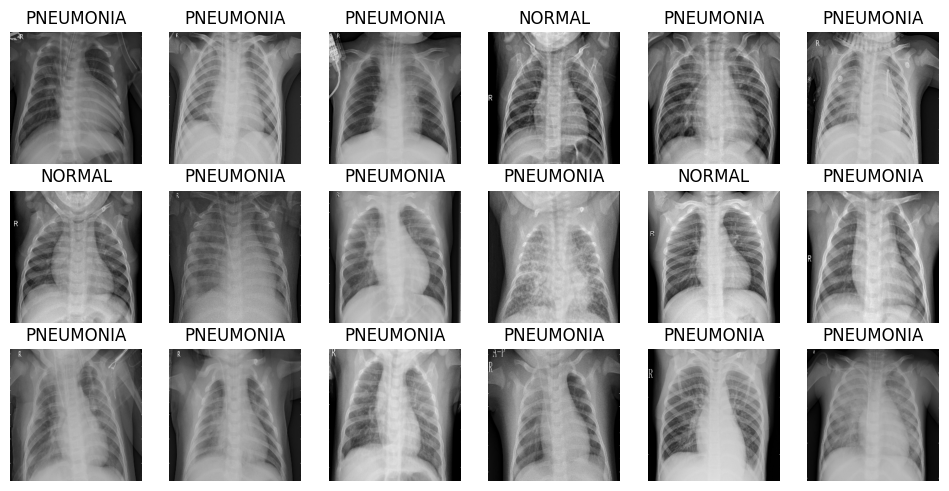

In [ ]:
plt.figure(figsize=(12, 12))

# Get class names from the training dataset
class_names = train_ds.class_names

# Display a few images from the dataset
for images, labels in train_ds.take(1):
    for i in range(min(18, len(images))):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Directly use the label as the class index (since it's already an integer)
        class_index = labels[i].numpy()

        plt.title(class_names[class_index])
        plt.axis("off")

plt.show()

In [ ]:
class_labels = ["Normal", "Pneumonia"]

### Data Pre-processing

In [ ]:
# resizing

def resize_images(image, label):
    image = tf.image.resize(image, [128, 128])
    return image, label

In [ ]:
# normalizing

def normalize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [ ]:
# grayscale conversion

def convert_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

In [ ]:
train_ds = train_ds.map(resize_images)
train_ds = train_ds.map(normalize_image)
train_ds = train_ds.map(convert_to_grayscale)

validation_ds = validation_ds.map(resize_images)
validation_ds = validation_ds.map(normalize_image)
validation_ds = validation_ds.map(convert_to_grayscale)

In [ ]:
def check_image_shape(dataset):
    for element in dataset.take(1):
        # Check if dataset has labels
        if isinstance(element, tuple) and len(element) == 2:
            images, labels = element
            print(f"Image shape: {images.shape}")
            print(f"Label shape: {labels.shape}")
        else:
            images = element
            print(f"Image shape: {images.shape}")
        break

check_image_shape(train_ds)

Image shape: (64, 128, 128, 1)
Label shape: (64,)


## Attention Module

In [ ]:
def attention_module(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(units=inputs.shape[-1] // 8, activation='relu')(x)
    x = Dense(units=inputs.shape[-1], activation='sigmoid')(x)
    return Multiply()([inputs, x])

### Defining Generator with Attention

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Concatenate, Dense, Reshape, Flatten, Dropout, Embedding, multiply
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

In [ ]:
def build_generator(input_shape=(128, 128, 1), num_classes=2):
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(1,))

    # Embedding and conditioning
    label_embedding = Flatten()(Embedding(num_classes, 100)(label_input))
    input_with_label = Multiply()([noise_input, label_embedding])

    x = Dense(128 * 8 * 8, activation="relu")(input_with_label)
    x = Reshape((8, 8, 128))(x)

    # Upsampling
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = attention_module(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = attention_module(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = attention_module(x)

    output = Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh')(x)  # Output shape: (128, 128, 1)

    return Model([noise_input, label_input], output, name="generator")

### Defining Discriminator with Conditioning

In [ ]:
def build_discriminator(input_shape=(128, 128, 1), num_classes=2):
    image_input = Input(shape=input_shape)  # Input for images
    label_input = Input(shape=(1,))         # Input for labels

    # Embed labels and reshape to match image size
    label_embedding = Flatten()(Embedding(num_classes, np.prod(input_shape))(label_input))
    label_embedding = Reshape(input_shape)(label_embedding)  # Reshape to image size

    # Concatenate image and label embeddings
    combined_input = Concatenate()([image_input, label_embedding])

    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(combined_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization(momentum = 0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Flatten and output a single value (real or fake)
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)

    return Model([image_input, label_input], output, name="discriminator")

## Defining GAN

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    noise_input = Input(shape=(100,))
    label_input = Input(shape=(1,))
    generated_image = generator([noise_input, label_input])
    gan_output = discriminator([generated_image, label_input])
    return Model([noise_input, label_input], gan_output, name="gan")

In [ ]:
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [ ]:
discriminator.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])
gan.compile(optimizer='adam', loss='hinge')

In [ ]:
def train_balanced_gan(generator, discriminator, gan, dataset, epochs=1000, batch_size=64):
    class_counts = {0: 0, 1: 0}

    for epoch in range(epochs):
        for real_images, labels in dataset:
            # Count class instances
            unique, counts = np.unique(labels.numpy(), return_counts=True)
            for u, c in zip(unique, counts):
                class_counts[u] += c

            # Set minority class for balancing
            minority_class = 0 if class_counts[0] < class_counts[1] else 1

            # Get the actual batch size from the data
            actual_batch_size = real_images.shape[0]

            noise = np.random.normal(0, 1, (actual_batch_size, 100))
            fake_labels = np.full((actual_batch_size, 1), minority_class)

            # Generate synthetic images
            generated_images = generator.predict([noise, fake_labels])

            # Create labels for training (use actual_batch_size)
            real_labels = np.ones((actual_batch_size, 1))
            fake_labels_gan = np.zeros((actual_batch_size, 1))

            # Train Discriminator
            d_loss_real = discriminator.train_on_batch([real_images, labels], real_labels)
            d_loss_fake = discriminator.train_on_batch([generated_images, fake_labels], fake_labels_gan)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            g_loss = gan.train_on_batch([noise, fake_labels], real_labels)

        print(f"Epoch {epoch} in progress...")

        if epoch % 10 == 0:
            print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")


In [ ]:
train_balanced_gan(generator, discriminator, gan, train_ds)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 64ms/step
Epoch 939 in progress...
1/1 [==============================] - 0s 71ms/step
Epoch 940 in progress...
Epoch 940 [D loss: 1.0206858105957508, acc.: 48.4375%] [G loss: 6.955862045288086e-05]
1/1 [==============================] - 0s 62ms/step
Epoch 941 in progress...
1/1 [==============================] - 0s 71ms/step
Epoch 942 in progress...
1/1 [==============================] - 0s 78ms/step
Epoch 943 in progress...
1/1 [==============================] - 0s 77ms/step
Epoch 944 in progress...
1/1 [==============================] - 0s 76ms/step
Epoch 945 in progress...
1/1 [==============================] - 0s 69ms/step
Epoch 946 in progress...
1/1 [==============================] - 0s 66ms/step
Epoch 947 in progress...
1/1 [==============================] - 0s 67ms/step
Epoch 948 in progress...
1/1 [==============================] - 0s 66ms/step
Epoch 949 in progress...
1/1 [==========

In [ ]:
def generate_balanced_samples(generator, num_samples_per_class=100):
    classes = [0, 1]                                       # 0 = Normal, 1 = Pneumonia
    all_generated_images = []
    all_generated_labels = []

    for class_label in classes:

        noise = np.random.normal(0, 1, (num_samples_per_class, 100))
        labels = np.array([class_label] * num_samples_per_class)
        generated_images = generator.predict([noise, labels])

        all_generated_images.append(generated_images)
        all_generated_labels.append(labels)

    balanced_images = np.concatenate(all_generated_images, axis=0)
    balanced_labels = np.concatenate(all_generated_labels, axis=0)

    return balanced_images, balanced_labels

In [ ]:
balanced_images, balanced_labels = generate_balanced_samples(generator)

4/4 [==============================] - 0s 38ms/step


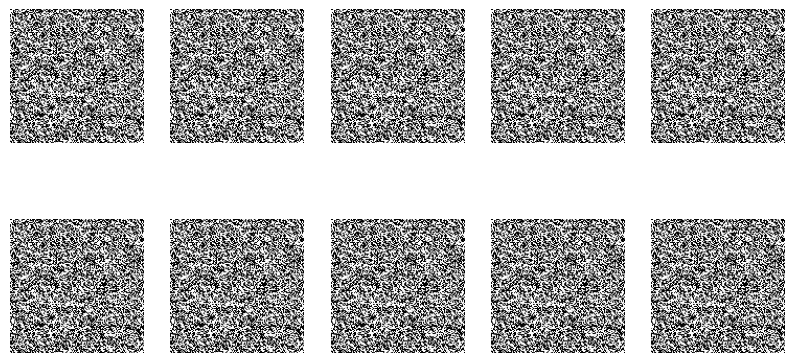

In [ ]:
def visualize_generated_samples(images, num_samples=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_generated_samples(balanced_images)

## Evaluation

In [ ]:
train_images_np = []
train_labels_np = []

for images, labels in train_ds:
    train_images_np.append(images.numpy())
    train_labels_np.append(labels.numpy())

# Stack the lists into single NumPy arrays
train_images_np = np.vstack(train_images_np)
train_labels_np = np.concatenate(train_labels_np)

In [ ]:
val_images_np = []
val_labels_np = []

for images, labels in validation_ds:
    val_images_np.append(images.numpy())
    val_labels_np.append(labels.numpy())

# Stack the lists into single NumPy arrays
val_images_np = np.vstack(val_images_np)
val_labels_np = np.concatenate(val_labels_np)

In [ ]:
# Combine generated images and labels with training dataset
train_images_np = np.vstack((train_images_np, balanced_images))
train_labels_np = np.concatenate((train_labels_np, balanced_labels))

In [ ]:
from sklearn.utils import shuffle
train_images_np, train_labels_np = shuffle(train_images_np, train_labels_np, random_state=42)


In [ ]:
# Print shapes for verification
print(f"Combined train images shape: {train_images_np.shape}")
print(f"Combined train labels shape: {train_labels_np.shape}")

# Validation dataset remains unchanged, but you can process it similarly if needed
print(f"Validation images shape: {val_images_np.shape}")
print(f"Validation labels shape: {val_labels_np.shape}")

Combined train images shape: (6216, 128, 128, 1)
Combined train labels shape: (6216,)
Validation images shape: (624, 128, 128, 1)
Validation labels shape: (624,)


In [ ]:
import random
from tensorflow.keras.regularizers import l2

In [ ]:
def create_model(learning_rate=0.01, dropout_rate=0.0, l2_reg=0.001):
    ui_cnn = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',
                               input_shape=(128, 128, 1), kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),
        tf.keras.layers.Dropout(dropout_rate),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=l2(l2_reg))
    ])

    ui_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return ui_cnn

In [ ]:
# Defining the hyperparameter search space

param_random = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3],
    'l2_reg': [0.001, 0.01],
    'epochs': [10],
    'batch_size': [32]
}

In [ ]:
best_params = None
best_score = -np.inf

In [ ]:
n_iter = 3

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
for _ in range(n_iter):

    learning_rate = random.choice(param_random['learning_rate'])
    dropout_rate = random.choice(param_random['dropout_rate'])
    l2_reg = random.choice(param_random['l2_reg'])  # Randomly choose L2 regularization strength
    epochs = random.choice(param_random['epochs'])
    batch_size = random.choice(param_random['batch_size'])

    print(f"Training model with Random Search = {learning_rate}, dropout = {dropout_rate}, l2_reg = {l2_reg}, epochs = {epochs}, batch_size = {batch_size}")
    model_cnn = create_model(learning_rate, dropout_rate, l2_reg)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model_cnn.fit(train_images_np, train_labels_np, validation_data = (val_images_np, val_labels_np), epochs = epochs, batch_size = batch_size, callbacks=[early_stopping], verbose = 0)

    # Get validation accuracy from the last epoch
    val_acc = history.history['val_accuracy'][-1]

    if val_acc > best_score:
        best_score = val_acc
        best_params = {
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'l2_reg': l2_reg,
            'epochs': epochs,
            'batch_size': batch_size
        }

Training model with Random Search = 0.1, dropout = 0.3, l2_reg = 0.001, epochs = 10, batch_size = 32
Training model with Random Search = 0.1, dropout = 0.2, l2_reg = 0.001, epochs = 10, batch_size = 32
Training model with Random Search = 0.1, dropout = 0.2, l2_reg = 0.001, epochs = 10, batch_size = 32


In [ ]:
final_model_cnn = create_model(learning_rate = best_params['learning_rate'], dropout_rate=best_params['dropout_rate'], l2_reg=best_params['l2_reg'])

In [ ]:
history_final = final_model_cnn.fit(train_images_np, train_labels_np, validation_data=(val_images_np, val_labels_np), epochs = best_params['epochs'], batch_size = best_params['batch_size'])

Epoch 1/10
195/195 [==============================] - 23s 109ms/step - loss: 5710.9238 - accuracy: 0.6726 - val_loss: 662.6897 - val_accuracy: 0.6250
Epoch 2/10
195/195 [==============================] - 21s 108ms/step - loss: 551.3283 - accuracy: 0.7037 - val_loss: 464.1443 - val_accuracy: 0.6250
Epoch 3/10
195/195 [==============================] - 20s 105ms/step - loss: 409.4814 - accuracy: 0.7037 - val_loss: 360.8035 - val_accuracy: 0.6250
Epoch 4/10
195/195 [==============================] - 21s 105ms/step - loss: 322.3373 - accuracy: 0.7038 - val_loss: 287.7733 - val_accuracy: 0.6250
Epoch 5/10
195/195 [==============================] - 20s 104ms/step - loss: 264.8685 - accuracy: 0.7043 - val_loss: 234.7666 - val_accuracy: 0.6250
Epoch 6/10
195/195 [==============================] - 21s 107ms/step - loss: 356.2482 - accuracy: 0.7033 - val_loss: 331.0802 - val_accuracy: 0.6250
Epoch 7/10
195/195 [==============================] - 21s 107ms/step - loss: 311.1318 - accuracy: 0.7032 

In [ ]:
final_model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 32, 32, 64)       

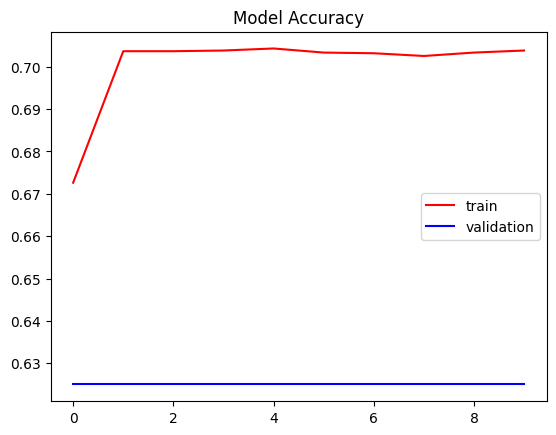

In [ ]:
plt.plot(history_final.history['accuracy'], color='red', label='train')
plt.plot(history_final.history['val_accuracy'], color='blue', label='validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_final.history['loss'], color='red', label='train')
plt.plot(history_final.history['val_loss'], color='blue', label='validation')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob = final_model_cnn.predict(val_images_np)
print("Shape of y_pred_prob after prediction:", y_pred_prob.shape)


y_pred = np.argmax(y_pred_prob, axis = 1)
print("Shape of y_pred after argmax:", y_pred.shape)

20/20 [==============================] - 1s 26ms/step
Shape of y_pred_prob after prediction: (624, 2)
Shape of y_pred after argmax: (624,)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
if val_labels_np.ndim == 2: #if multilabel
    val_labels_np = np.argmax(val_labels_np, axis=1)

In [ ]:
accuracy = accuracy_score(val_labels_np, y_pred)
precision = precision_score(val_labels_np, y_pred, average = 'weighted')
recall = recall_score(val_labels_np, y_pred, average = 'weighted')
f1 = f1_score(val_labels_np, y_pred, average = 'weighted')

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7018
Precision: 0.7006
Recall: 0.6650
F1 Score: 0.6808


In [ ]:
plt.figure(figsize = (16, 12))

cm = confusion_matrix(val_labels_np, y_pred)

<Figure size 1600x1200 with 0 Axes>

In [ ]:
from matplotlib.colors import LogNorm

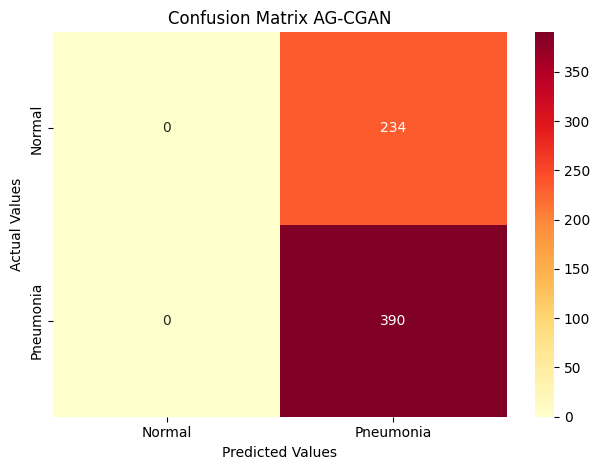

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels,
            cmap='YlOrRd')
plt.title('Confusion Matrix AG-CGAN')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(val_labels_np, y_pred, target_names = class_labels)
print(cr)

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

